# **Black Friday Sale Predictions - Group 07 - DSAI - K65** 

*Colab Version*

**Table of contents** 
1. [Setup the datasets](#setup-data)
2. [Import necessary libraries](#import-libraries)
3. [Data preparation](#data-preparation)
4. [Choosing data preprocessing for the model](#choose-data-preprocessing)
5. [Setup metrics, basic plots, and seed for mdel evaluation](#setup-model)
6. [Modelling and evaluation](#model)
7. [Conclusion](#conclusion)

<a name="setup-data"></a>
## 1.&nbsp;Setup the datasets

Download file data .zip from Google Drive

In [ ]:
!gdown 1ch8GFCDyeP3DPJIADOYN1mdHs21x__5T

Downloading...
From: https://drive.google.com/uc?id=1ch8GFCDyeP3DPJIADOYN1mdHs21x__5T
To: /content/BlackFridayDatasets.zip
100% 7.70M/7.70M [00:00<00:00, 107MB/s]


Unzip the downloaded data file

In [ ]:
FOLDER_PATH = r'/content/BlackFridayDatasets/'
!unzip -o "/content/BlackFridayDatasets.zip" -d  $FOLDER_PATH

Archive:  /content/BlackFridayDatasets.zip
  inflating: /content/BlackFridayDatasets/data_description.txt  
  inflating: /content/BlackFridayDatasets/test.csv  
  inflating: /content/BlackFridayDatasets/train.csv  


Setup folder path for the training test and test dataset

In [ ]:
TRAIN_DATA_PATH = FOLDER_PATH + r'train.csv'
TEST_DATA_PATH = FOLDER_PATH + r'test.csv'

Check whether we are in the right paths

In [ ]:
import os 
print("All files in folder data are: " + str(os.listdir(FOLDER_PATH)))
print("Is exists train file? " + str(os.path.exists(TRAIN_DATA_PATH)))
print("Is exists test file? " + str(os.path.exists(TEST_DATA_PATH)))

All files in folder data are: ['data_description.txt', 'train.csv', 'test.csv']
Is exists train file? True
Is exists test file? True


*Our expected output is:* 
```
All files in folder data are: ['test.csv', 'train.csv', 'data_description.txt']
Is exists train file? True
Is exists test file? True
```


**Now we are ready to move on to the main part of the notebook.**

<a name="import-libraries"></a>
##2.&nbsp;Import necessary libraries

In [ ]:
import time
import random
import math


import gc; gc.enable() #Enable garbage for the notebook

import numpy as np 
import pandas as pd

# Plot diagrams 
import matplotlib.pyplot as plt
import seaborn as sns

## Sklearn for data preprocessing modelling,  and evaluation 
from sklearn.model_selection import cross_validate, validation_curve, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

## For xgboost model
from xgboost import XGBRegressor


## For normal test
from scipy.stats import normaltest

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


## Setup graph style
import matplotlib.style as style
style.use('seaborn-poster')
style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'monospace'

<a name="data-preparation"></a>
##3.&nbsp;Data preparation

### 3.1. Exploratory Data Analysis (EDA)

In [ ]:
# Read data from csv file
train_raw = pd.read_csv(TRAIN_DATA_PATH)
test_raw = pd.read_csv(TEST_DATA_PATH)

In [ ]:
# Let's see some data
train_raw.head(6)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227


In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


 We can easy notice that all non-target attributes are categorical (more specifically nominal).

 There is no missing information related to users but there are large numbers of null values for products (Product_Category_2,  Product_Category_3). 

Now, let's look closer on user profile. We need to get number of items each user have bought and total money they spent for these products

In [ ]:
user_df = train_raw.iloc[:, [0, 2, 3, 4, 5, 6, 7, 11]]

u1 = user_df.groupby(by='User_ID', as_index=False).agg({'Purchase':'sum'})
u1.rename(columns={"Purchase":"Total_Purchase"}, inplace=True)
u2 = user_df.groupby(by='User_ID', as_index=False).agg({'Purchase':'count'})
u2.rename(columns={'Purchase':'nb_products_purchased'}, inplace=True)

user_df = pd.merge(user_df, u1, on='User_ID')
user_df = pd.merge(user_df, u2, on='User_ID')
user_df.drop(columns="Purchase", inplace=True)  

user_df.drop_duplicates(inplace=True)           # drop duplicated
user_df.reset_index(inplace=True, drop=True)    # reset index for user_df
user_df.head(4)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Total_Purchase,nb_products_purchased
0,1000001,F,0-17,10,A,2,0,334093,35
1,1000002,M,55+,16,C,4+,0,810472,77
2,1000003,M,26-35,15,A,3,0,341635,29
3,1000004,M,46-50,7,B,2,1,206468,14


Now, we use this dataframe to analyize user profile

In [ ]:
gender = user_df.Gender.value_counts()
gender

M    4225
F    1666
Name: Gender, dtype: int64

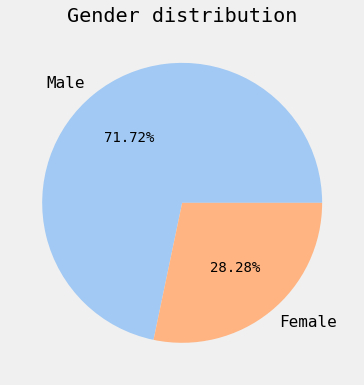

In [ ]:
gender = user_df.Gender.value_counts()
labels = ['Male', 'Female']
colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(6,6))
plt.pie(gender, labels=labels,colors= colors, autopct='%.2f%%')
plt.title("Gender distribution")

plt.savefig("gender.png")
plt.show()

It's clearly that # males significantly higher than # female customers, about 2.5 times. 

So, how about customers' age distribution??

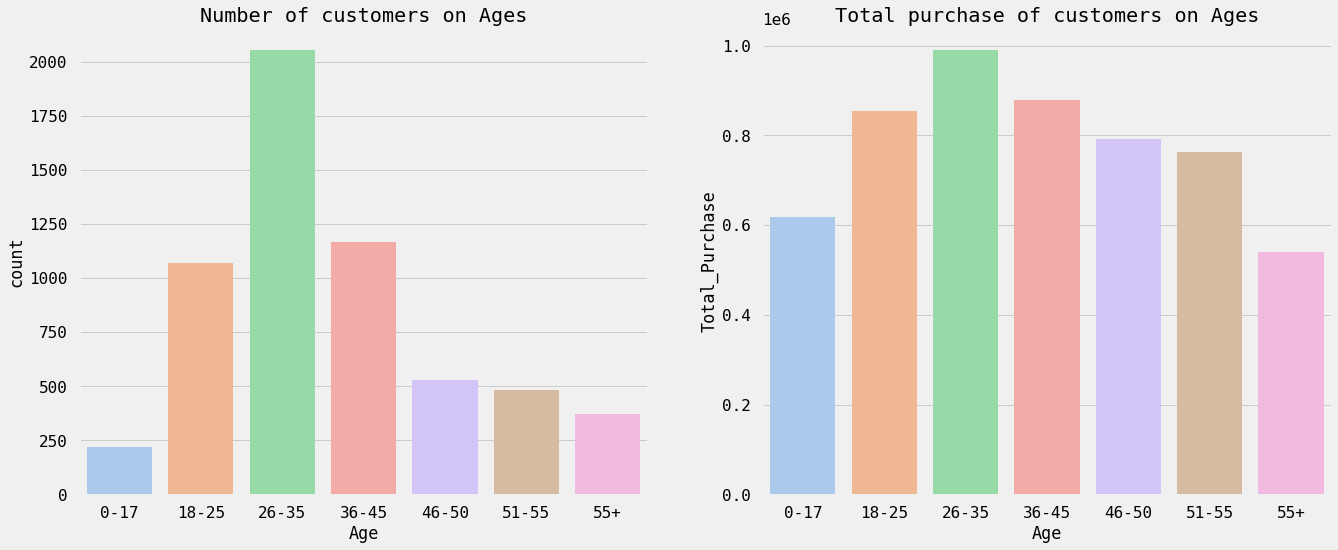

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (20,8))

sns.countplot(ax=ax[0], data=user_df, x='Age', palette='pastel', order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'])
sns.barplot(ax=ax[1], data=user_df, x='Age', y='Total_Purchase', palette='pastel', ci=False, order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'])

ax[0].set(title="Number of customers on Ages")
ax[1].set(title="Total purchase of customers on Ages")
plt.savefig('age_count_purchase.png')
plt.show()

In general, there are customers with young population age, in which customers from 26-35 years old are predominate in terms of size.

The average total money for products according to each group of age are not too different.

In [ ]:
job_order = user_df.Occupation.sort_values()
job_order.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

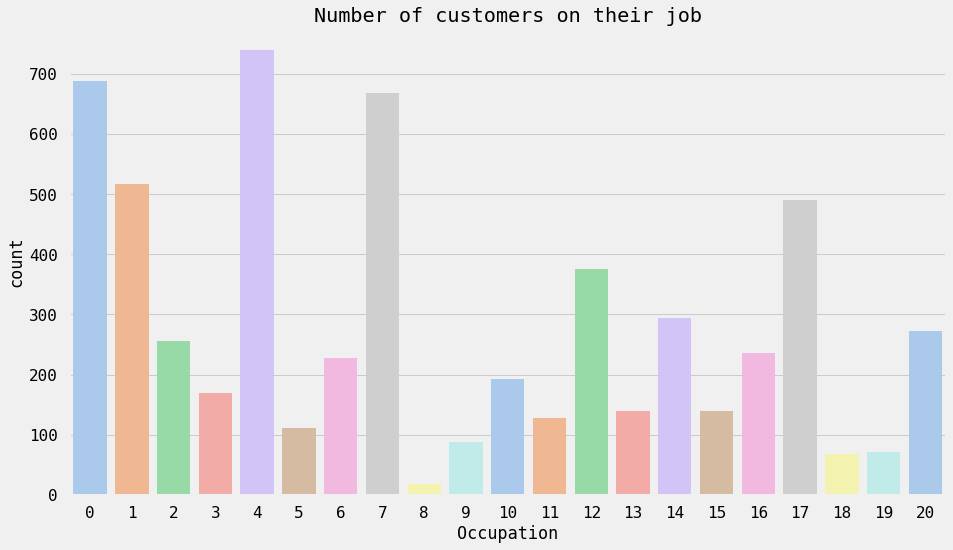

In [ ]:
job_order = user_df.Occupation.sort_values().unique()

plt.figure(figsize=(14,8))
sns.countplot(data=user_df, x='Occupation', palette='pastel', order=job_order)
plt.title("Number of customers on their job")

plt.savefig('job_count.png')
plt.show()

Job 0, 4, 7 are popular, whereas 8, 18, 19 are top 3 of jobs which have least customers participates.

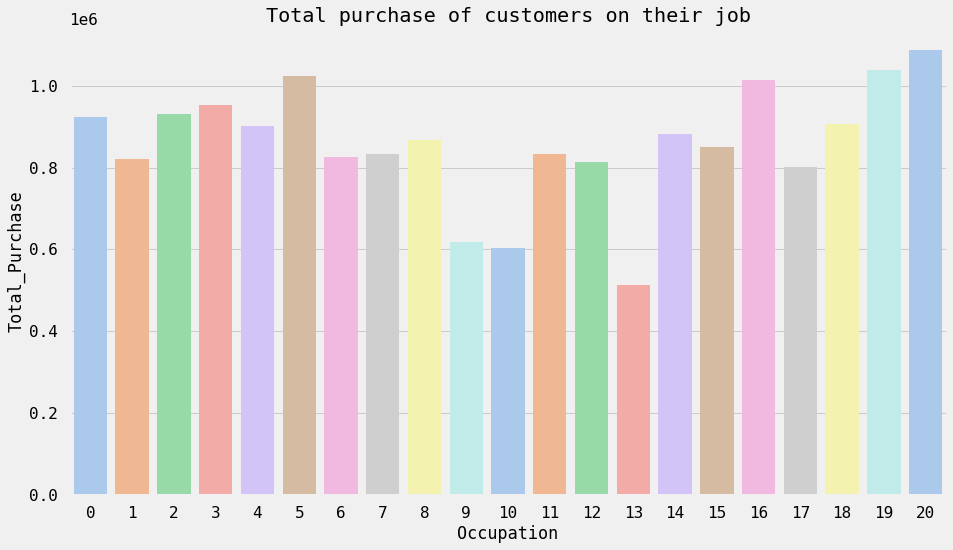

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(data=user_df, x='Occupation',y='Total_Purchase', palette='pastel', order=job_order, ci=False)
plt.title("Total purchase of customers on their job")

plt.savefig('job_purchase.png')
plt.show()

The average money users spent for product according to their job are quite similar, the highest is job 20 and the lowest is job 13.

Now, take a look on customers' living location.

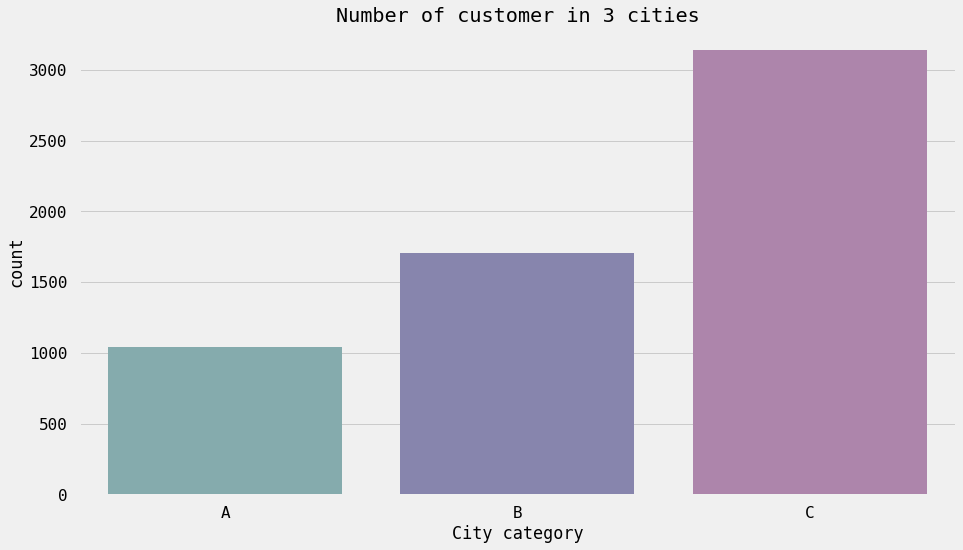

In [ ]:
plt.figure(figsize=(14,8))
sns.countplot(data=user_df, x='City_Category', order=['A', 'B', 'C'], palette=sns.color_palette('hls')[3:], saturation=0.3)

plt.title("Number of customer in 3 cities")
plt.xlabel("City category")

plt.savefig("city_nb.png")
plt.show()

Looking at the figure, there is no doubt that number of users in *city C* is the highest, over 3 times higher than # users in *city A* and as twice as many # users in *city B*. And how about their shopping behaviour? 

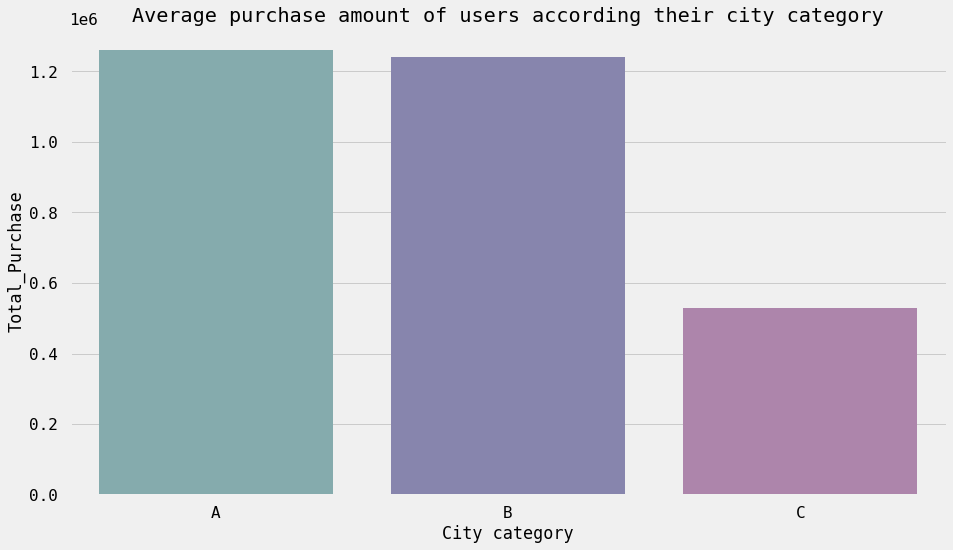

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(data=user_df, x='City_Category', y='Total_Purchase', order=['A', 'B', 'C'], palette=sns.color_palette('hls')[3:], saturation=0.3, ci=False)

plt.title("Average purchase amount of users according their city category")
plt.xlabel("City category")

plt.savefig("city_purchase.png")
plt.show()

We surprised that the average amount of money each customers in *city C* paid for products is the lowest. Citizens in *city A* and *city B* have a similar purchase behaviour since they spent similar amount of money. 

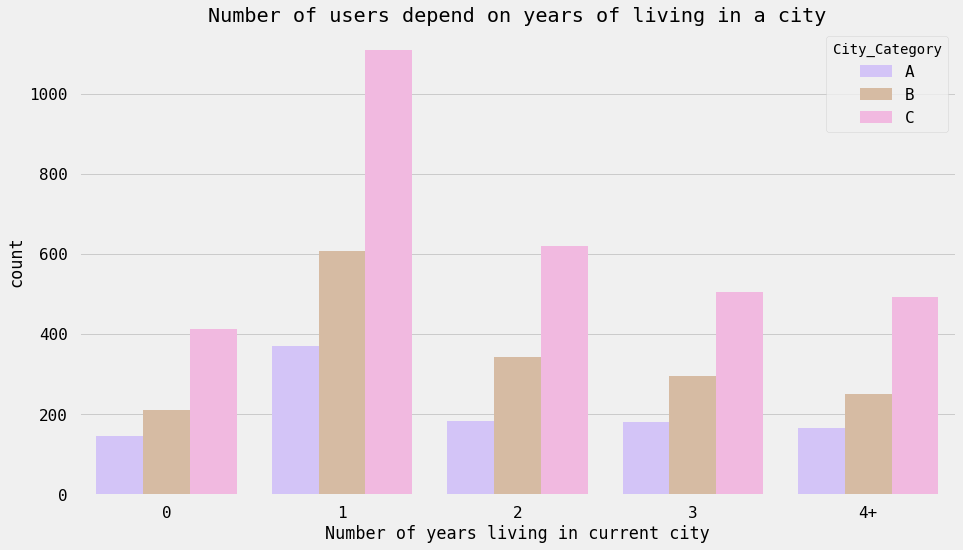

In [ ]:
year_in_city_order = user_df.Stay_In_Current_City_Years.sort_values().unique()

plt.figure(figsize=(14,8))
sns.countplot(data=user_df, x='Stay_In_Current_City_Years', hue='City_Category', order=year_in_city_order, hue_order=['A', 'B', 'C'], palette= sns.color_palette('pastel')[4:7])

plt.title('Number of users depend on years of living in a city')
plt.xlabel('Number of years living in current city')

plt.savefig('nb_user_yearliving_citycate.png')
plt.show()

Number of customers who live 1 year in *city C* is surprisingly high, while the rests do not have many things to analyze.

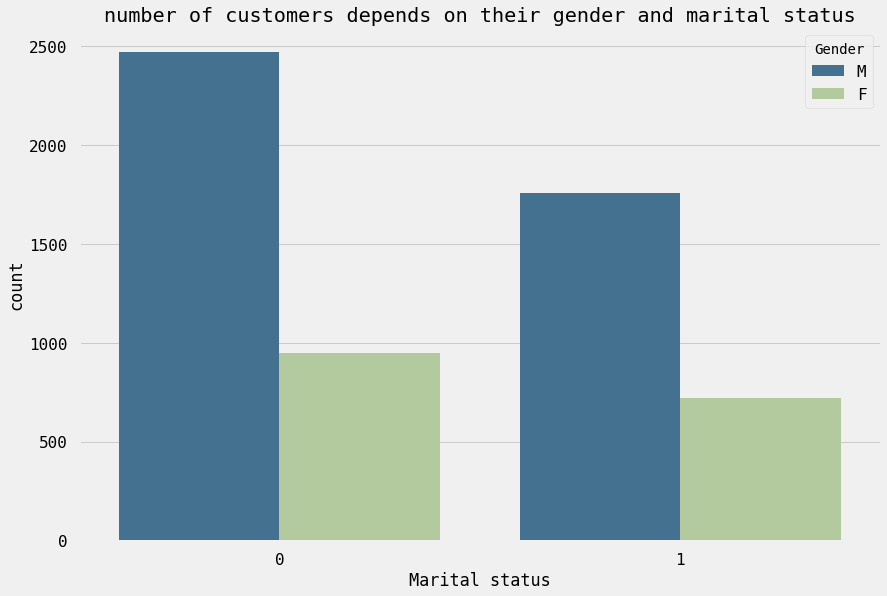

In [ ]:
sns.countplot(data=user_df, x='Marital_Status', hue='Gender', order=[0, 1], hue_order= ['M', 'F'], palette = sns.color_palette('Paired')[1:], saturation=0.5)

plt.title("number of customers depends on their gender and marital status")
plt.xlabel('Marital status')

plt.savefig('marital_age.png')
plt.show()

Both male and female customers have a higher number of unmarried people than married people.

And any relationship between user marital status and their age? 

In [ ]:
ms_labels = ['Not married', 'Married']
colors = sns.color_palette('pastel')[4:]

marital_status = user_df.Marital_Status.value_counts()
marital_status

0    3417
1    2474
Name: Marital_Status, dtype: int64

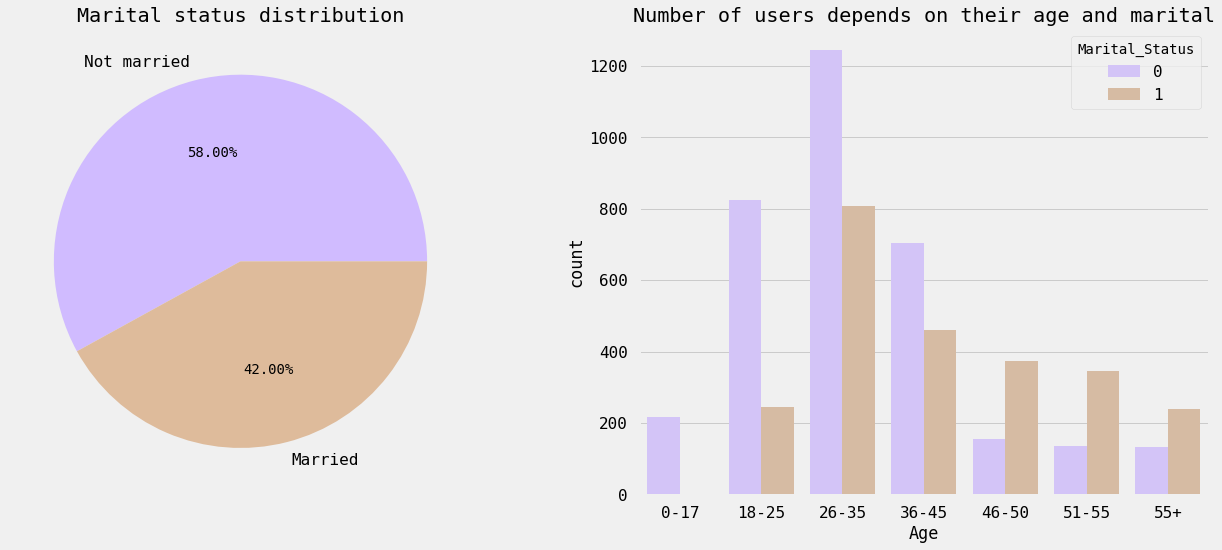

<Figure size 864x576 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (20,8))
plt.figure(figsize=(12,8))
ax[0].pie(x= marital_status, labels=ms_labels, colors= colors, autopct='%.2f%%')
sns.countplot(ax=ax[1], data=user_df, x='Age', hue='Marital_Status', order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'], palette= colors)
ax[0].set(title="Marital status distribution")
ax[1].set(title="Number of users depends on their age and marital")

plt.savefig('marital_dis_age.png')
plt.show()

58% of customers are not married. 

Customers from 0-17 years old do not have wife or husband, obviously.
Under 45 years old, in every group of age, number of unmarried users is taking the lead.
Over 45 years old, users who already get married are higher than that number who unmarried in all group of age. 

And how about total amount of money each group spent for products?

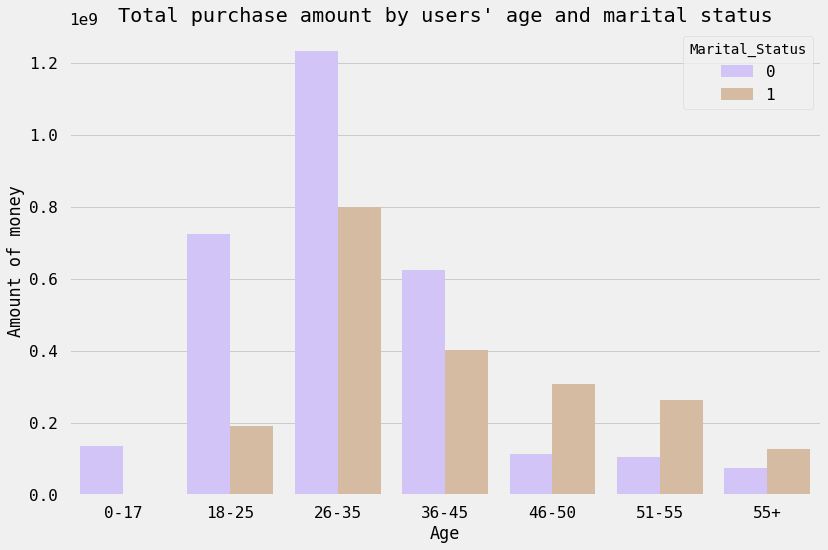

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot( data=user_df, x='Age', y='Total_Purchase', hue='Marital_Status', order=['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'], palette= colors, ci=False, estimator=np.sum)

plt.title("Total purchase amount by users' age and marital status")
plt.ylabel("Amount of money")
plt.savefig('total_marital_age.png')
plt.show()

Now, we need some information about product details.

In [ ]:
product_df = train_raw.iloc[:, [1, 8,9,10,11]]
product_df.head()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,P00069042,3,NaN,NaN,8370
1,P00248942,1,6.0,14.0,15200
2,P00087842,12,NaN,NaN,1422
3,P00085442,12,14.0,NaN,1057
4,P00285442,8,NaN,NaN,7969


We also need some information about total money and total number of user have been paid for a product. 

The following code have solved:

In [ ]:
product_df = train_raw.iloc[:, [1, 8, 9, 10, 11]]

p1 = product_df.groupby(by='Product_ID', as_index=False).agg({'Purchase':'count'})      
p1.rename(columns={'Purchase':'nb_users_purchased'}, inplace=True)                      # p1 contains 'Product_ID' and 'number of users have been paid for that product'
p2 = product_df.groupby(by='Product_ID', as_index=False).agg({'Purchase':'sum'})
p2.rename(columns={'Purchase':'Total_amount'}, inplace=True)                            # p2 contains 'Product_ID' and 'total money have been spent for that products'


product_df = pd.merge(product_df, p1, on="Product_ID")                                  # merging p1 and p2 depends on 'Product_ID' 
product_df = pd.merge(product_df, p2, on="Product_ID")

product_df.drop(columns='Purchase', inplace=True)
product_df.drop_duplicates(inplace=True)

product_df.reset_index(drop=True, inplace=True) # reset indexing of dataframe
product_df.head() # now we use product_df for analyzing product details

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,nb_users_purchased,Total_amount
0,P00069042,3,NaN,NaN,227,2694686
1,P00248942,1,6.0,14.0,581,9472642
2,P00087842,12,NaN,NaN,102,126265
3,P00085442,12,14.0,NaN,341,496203
4,P00285442,8,NaN,NaN,203,1561631


In [ ]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product_ID          3631 non-null   object 
 1   Product_Category_1  3631 non-null   int64  
 2   Product_Category_2  1803 non-null   float64
 3   Product_Category_3  528 non-null    float64
 4   nb_users_purchased  3631 non-null   int64  
 5   Total_amount        3631 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 170.3+ KB


Since *Product_Category_2* and *Product_Category_3* have a large number of NaN values, we assume that *Product_Category_1* is the main category of a product. 

Moreover, we focus on analyze Category 1 for understanding more about the product details.

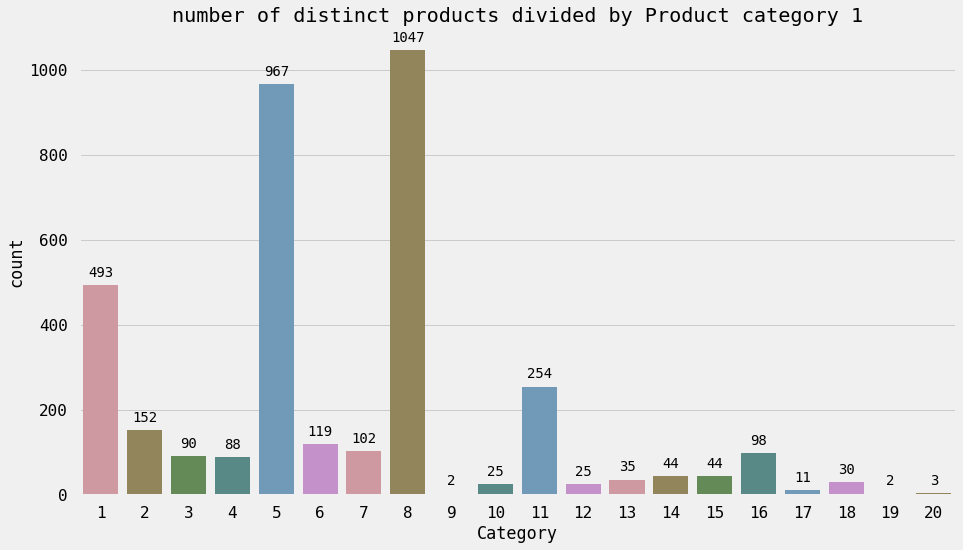

In [ ]:
cate1 = product_df.Product_Category_1.value_counts().sort_index()        # cate 1 contains category 1 and number of products in that category
labels=cate1.index                                                          # use cate1 for preprocessing
values=cate1.values

plt.figure(figsize = (14, 8))
ax = sns.barplot(x=labels, y=values, palette = sns.color_palette('husl'), saturation=0.4)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 20, values[i],ha="center")

plt.xlabel('Category')
plt.ylabel("count")
plt.title("number of distinct products divided by Product category 1")

plt.savefig('nb_product_cate1.png')
plt.show()

We can easily imply that category *8* and *5* maybe essential products, which have many kind of products, while *9, 19, 20* are top 3 of categories which have least type of products.

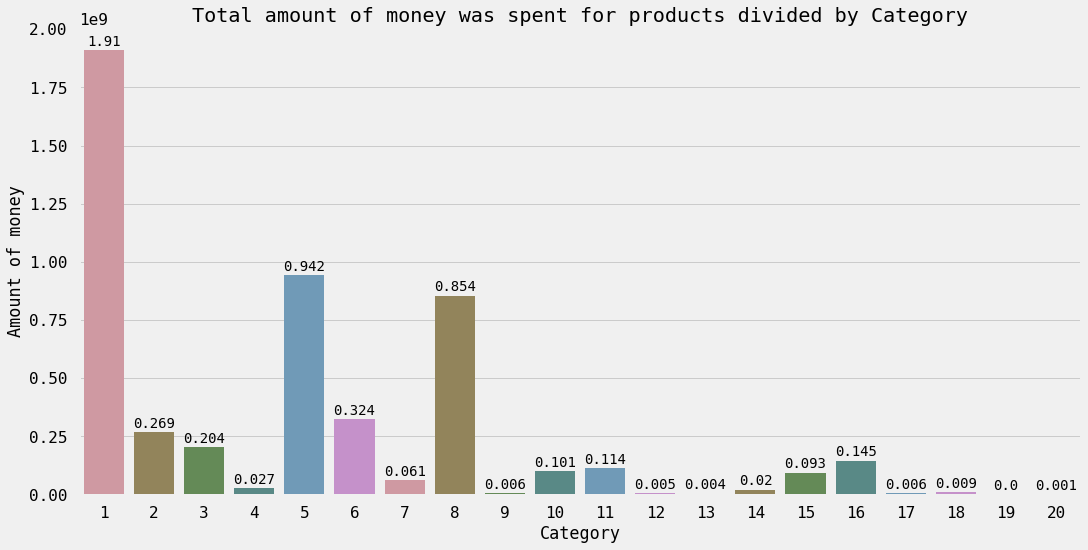

In [ ]:
cate1_amount = product_df.groupby(by='Product_Category_1', as_index=False).agg({'Total_amount':'sum'}) #use cate1_amount for preprocessing
prod = list(cate1_amount.Product_Category_1)
am_purchase = list(cate1_amount.Total_amount)

plt.figure(figsize = (16, 8))
ax = sns.barplot(x=prod, y=am_purchase, palette = sns.color_palette('husl'), saturation=0.4)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 20000000, round(am_purchase[i]/ 1000000000, 3), ha="center")

plt.title("Total amount of money was spent for products divided by Category")
plt.xlabel("Category")
plt.ylabel("Amount of money")

plt.savefig('total_cate.png')
plt.show()

Althought category *8* has the many types of products, the total amount for this category is only lower than $\frac{1}{2}$ of that for category *1*.



However, we cannot forget *Product_Category_2* and *Product_Category_3* just because of lack of information. We consider a *Versatile score* which involve all 3 *Product_Category_* with an assumption that a product is more versatile if it belongs to more categories. 

The following code derived a new attribute *Versatile*


In [ ]:
product_df['Versatile'] = 3 - product_df.iloc[:,[1, 2, 3]].isnull().sum(axis = 1)
product_df.head(4)

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,nb_users_purchased,Total_amount,Versatile
0,P00069042,3,NaN,NaN,227,2694686,1
1,P00248942,1,6.0,14.0,581,9472642,3
2,P00087842,12,NaN,NaN,102,126265,1
3,P00085442,12,14.0,NaN,341,496203,2


Now, we will explore some information about new attribute

In [ ]:
versatile = product_df.Versatile.value_counts()
versatile

1    1828
2    1275
3     528
Name: Versatile, dtype: int64

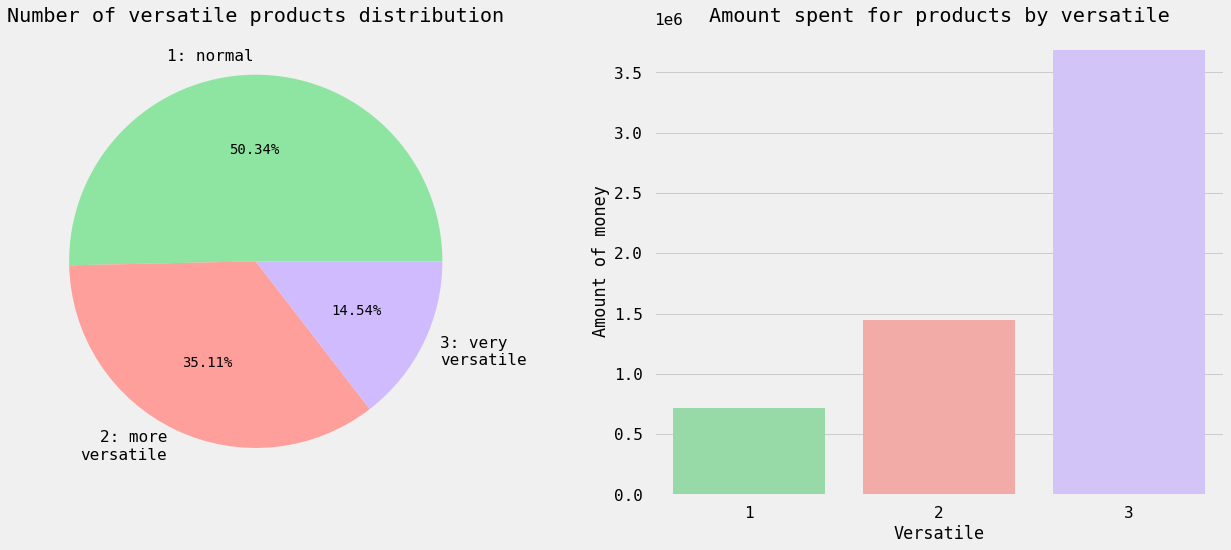

In [ ]:
versatile = product_df.Versatile.value_counts()
labels = ["1: normal", "2: more\nversatile", "3: very\nversatile"]
colors = sns.color_palette('pastel')[2:5]


fig, ax = plt.subplots(1,2, figsize= (20,8))

ax[0].pie(versatile, labels=labels,colors= colors, autopct='%.2f%%')
sns.barplot(data=product_df, x='Versatile', y='Total_amount', ax=ax[1], ci=False, palette=colors)


ax[0].set(title='Number of versatile products distribution')
ax[1].set(title='Amount spent for products by versatile', ylabel="Amount of money")

plt.savefig("versatile.png")
plt.show()

As we can see, over *50\%* of products are normal, that means belongs to only 1 category, number of percentage of very versatile product is *14.54\%*, lowest of 3 types.
But users spent most for products which very versatile.

How about the distribution of average amount an user spent for a product? 

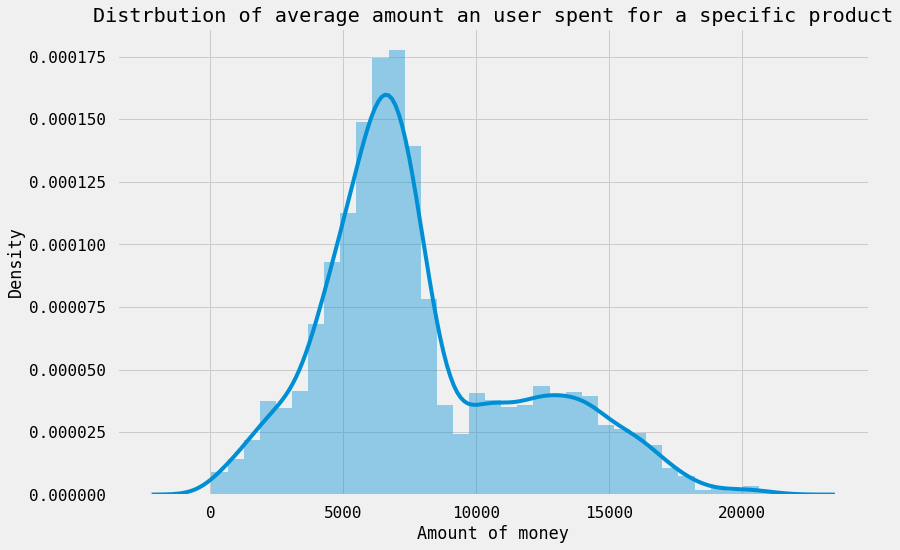

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot( x=product_df.Total_amount / product_df.nb_users_purchased, kde=True)

plt.xlabel("Amount of money")
plt.title("Distrbution of average amount an user spent for a specific product")

plt.savefig('dis_avg_money_per_product.png')
plt.show()

In [ ]:
p1 = product_df.loc[:, ['Product_ID', 'Product_Category_1', 'Total_amount', "nb_users_purchased", 'Versatile' ]]
p1['avg_a_user_purchased'] = round(p1.Total_amount / p1.nb_users_purchased)   
p1.head()       # note that we will it later

,Product_ID,Product_Category_1,Total_amount,nb_users_purchased,Versatile,avg_a_user_purchased
0,P00069042,3,2694686,227,1,11871.0
1,P00248942,1,9472642,581,3,16304.0
2,P00087842,12,126265,102,1,1238.0
3,P00085442,12,496203,341,2,1455.0
4,P00285442,8,1561631,203,1,7693.0


In [ ]:
p1.sort_values(by='avg_a_user_purchased')

,Product_ID,Product_Category_1,Total_amount,nb_users_purchased,Versatile,avg_a_user_purchased
3630,P00370853,19,30588,818,1,37.0
3628,P00370293,19,28790,785,1,37.0
3629,P00371644,20,326257,899,1,363.0
3626,P00375436,20,304653,814,1,374.0
3627,P00372445,20,313817,837,1,375.0
...,...,...,...,...,...,...
332,P00119342,10,6298217,308,2,20449.0
695,P00116142,10,13137754,642,3,20464.0
844,P00200642,10,5506100,269,2,20469.0
1274,P00085342,10,11581108,552,2,20980.0


The distribution does not follow Normal Distribution. There are 2 peaks, the highest density is about *\$6000* and the second peak is about *\$13500*



Until now, our team still have some question that need to explore data in higher level to specify the answer.
 Which type of users spent most money on buying products? 

We continue to use user_df in previous section to find the answer

In [ ]:
user_df.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Total_Purchase,nb_products_purchased
0,1000001,F,0-17,10,A,2,0,334093,35
1,1000002,M,55+,16,C,4+,0,810472,77
2,1000003,M,26-35,15,A,3,0,341635,29
3,1000004,M,46-50,7,B,2,1,206468,14
4,1000005,M,26-35,20,A,1,1,821001,106


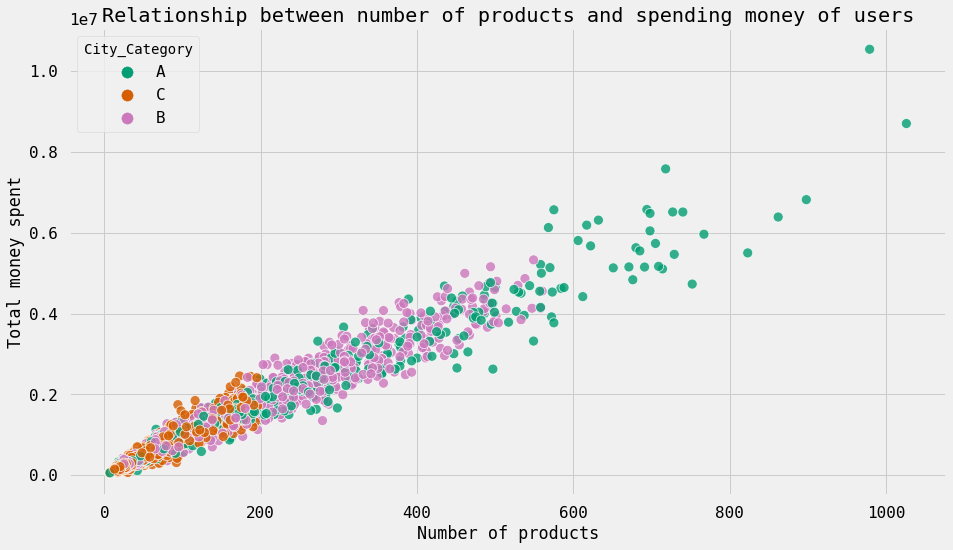

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=user_df, x='nb_products_purchased', y='Total_Purchase', hue="City_Category", s=100, palette=sns.color_palette('colorblind')[2:5], alpha = 0.8)

plt.title("Relationship between number of products and spending money of users")
plt.ylabel("Total money spent")
plt.xlabel("Number of products")

plt.show()

It's hard to see any data point that belongs to users in *city C* and have more that 200 products purchased.

In general, a normal user usually by lower than 400 products, but some of users in *city A* buy more and total money these people spent for product also the highest 

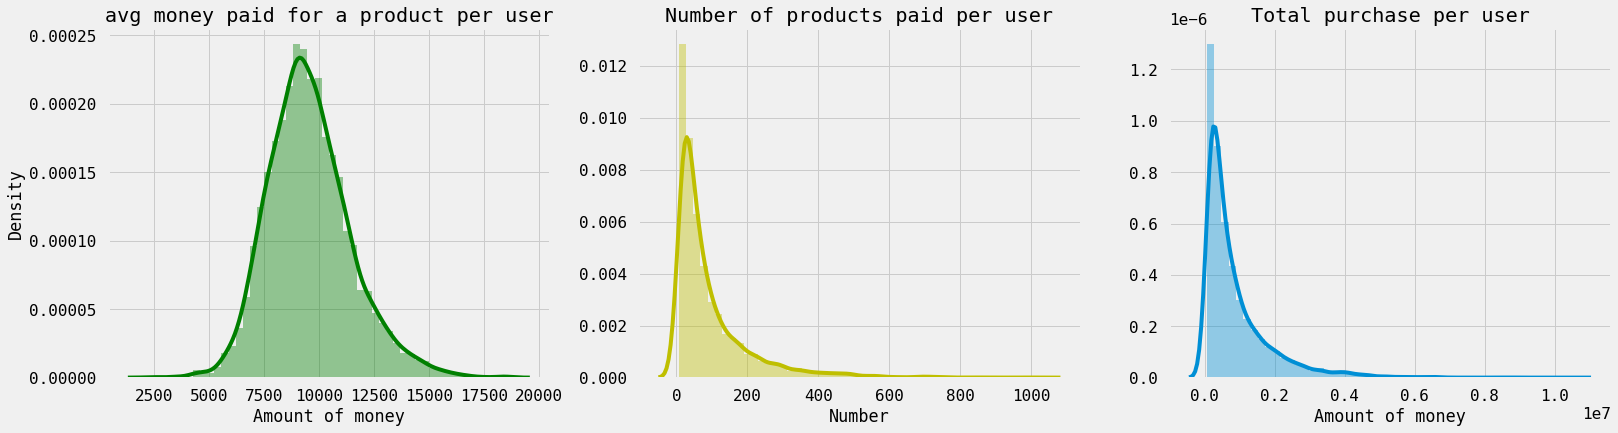

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (24,6))

sns.distplot(ax= ax[0], x=user_df.Total_Purchase / user_df.nb_products_purchased, kde=True, color='g')
sns.distplot(ax= ax[1], x= user_df.nb_products_purchased, kde= True, color='y')
sns.distplot(ax=ax[2], x= user_df.Total_Purchase, kde = True)
ax[0].set(title="avg money paid for a product per user", xlabel="Amount of money")
ax[1].set(title="Number of products paid per user", ylabel = None, xlabel="Number")
ax[2].set(title="Total purchase per user", xlabel="Amount of money", ylabel=None)

plt.show() 

General, the average money spent for a product distribution forms a bell shape, where it reachs the peak at x arounds *9000* .
The others distributions are not really bell shape, which not really help us.

We decide to user average money spent for a product as an attribute for our problem


In [ ]:
user_df['avg_amount_per_product'] = round(user_df.Total_Purchase / user_df.nb_products_purchased, 2)
user_df.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Total_Purchase,nb_products_purchased,avg_amount_per_product
0,1000001,F,0-17,10,A,2,0,334093,35,9545.51
1,1000002,M,55+,16,C,4+,0,810472,77,10525.61
2,1000003,M,26-35,15,A,3,0,341635,29,11780.52
3,1000004,M,46-50,7,B,2,1,206468,14,14747.71
4,1000005,M,26-35,20,A,1,1,821001,106,7745.29


In [ ]:
product_df.head()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,nb_users_purchased,Total_amount,Versatile
0,P00069042,3,NaN,NaN,227,2694686,1
1,P00248942,1,6.0,14.0,581,9472642,3
2,P00087842,12,NaN,NaN,102,126265,1
3,P00085442,12,14.0,NaN,341,496203,2
4,P00285442,8,NaN,NaN,203,1561631,1


### 3.2. Data Preprocessing 
&nbsp; &nbsp; *based on our EDA.*

In this part, we list all potential preprocessing data methods to try out and pick the best one. 


*Input:* Training and test set

*Output:* `X`: training set (without labels), `y`: training labels, `X_test`: test set for prediction

Some utils functions

In [ ]:
def get_train_user_df(train_df: pd.DataFrame):
    user_df = train_raw.iloc[:, [0, 2, 3, 4, 5, 6, 7, 11]]

    u1 = user_df.groupby(by='User_ID', as_index=False).agg({'Purchase':'sum'})
    u1.rename(columns={"Purchase":"Total_Purchase"}, inplace=True)
    u2 = user_df.groupby(by='User_ID', as_index=False).agg({'Purchase':'count'})
    u2.rename(columns={'Purchase':'nb_products_purchased'}, inplace=True)

    user_df = pd.merge(user_df, u1, on='User_ID')
    user_df = pd.merge(user_df, u2, on='User_ID')
    user_df.drop(columns="Purchase", inplace=True)  

    user_df.drop_duplicates(inplace=True)           # drop duplicated
    user_df.reset_index(inplace=True, drop=True)

    user_df['avg_amount_per_product'] = round(user_df.Total_Purchase / user_df.nb_products_purchased, 2)
    
    return user_df 


def get_train_product(train_df:pd.DataFrame):
    product_df = train_raw.iloc[:, [1, 8, 9, 10, 11]]

    p1 = product_df.groupby(by='Product_ID', as_index=False).agg({'Purchase':'count'})      
    p1.rename(columns={'Purchase':'nb_users_purchased'}, inplace=True)                      # p1 contains 'Product_ID' and 'number of users have been paid for that product'
    p2 = product_df.groupby(by='Product_ID', as_index=False).agg({'Purchase':'sum'})
    p2.rename(columns={'Purchase':'Total_amount'}, inplace=True)                            # p2 contains 'Product_ID' and 'total money have been spent for that products'


    product_df = pd.merge(product_df, p1, on="Product_ID")                                  # merging p1 and p2 depends on 'Product_ID' 
    product_df = pd.merge(product_df, p2, on="Product_ID")

    product_df.drop(columns='Purchase', inplace=True)
    product_df.drop_duplicates(inplace=True)

    product_df['Versatile'] = 3 - product_df.iloc[:,[1, 2, 3]].isnull().sum(axis = 1)
    product_df['avg_purchase_amount'] = round(product_df.Total_amount / product_df.nb_users_purchased, 2)
    product_df.reset_index(drop=True, inplace=True)

    return product_df

Data preprocessing functions

In [ ]:
def simple_data_preprocessing(train_raw: pd.DataFrame, test_raw: pd.DataFrame):
  '''
    Simple data processing without thinking about data relationship too much
  '''
  le = LabelEncoder()

  df_train = train_raw.copy()
  df_test = test_raw.copy()


  df_train.drop(columns = ['Product_Category_2', 'Product_Category_3'], inplace=True)
  df_test.drop(columns = ['Product_Category_2', 'Product_Category_3'] , inplace=True)


  idx = df_train.shape[0]

  y  = df_train['Purchase']
  df_train.drop('Purchase', 1 , inplace= True)

  df_train_test = pd.concat([df_train, df_test], axis = 0)

  columns = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation' , 'City_Category' , 'Stay_In_Current_City_Years']

  for col in columns:
    df_train_test[col] = le.fit_transform(df_train_test[col])



  X = df_train_test.iloc[:idx, :]
  test_encode = df_train_test.iloc[idx: , :]

  return X, y , test_encode


def lazy_preprocessing(train_df: pd.DataFrame, test_df: pd.DataFrame):
    '''
        Normal LabelEncoder with some knowledge from EDA section
    '''

    product_df = get_train_product(train_df)
    cate1_amount = product_df.groupby(by='Product_Category_1', as_index=False).agg({'Total_amount':'sum'})
    
    le = LabelEncoder()
    df_train = train_df.copy()
    df_test = test_df.copy()

        # divide training set into 2 parts, df_train and y
    y = df_train.loc[:, 'Purchase']
    df_train.drop(columns='Purchase', inplace=True)

        # Applied *Versatile Score* from EDA section
    df_train['Versatile'] = 3 - df_train.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)
    df_test['Versatile'] = 3 - df_test.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)

        # Drop *Product_Category_2* and *Product_Category_3*
    df_train.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)
    df_test.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)

    columns = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'Stay_In_Current_City_Years']

        # encoding train set and test set at same time
    idx = df_train.shape[0]
    train_test = pd.concat([df_train, df_test], axis=0)

        # encoding 
    for column in columns:
        train_test[column] = le.fit_transform(train_test[column])
    
    train_test['City_Category'] = le.fit(['C', 'B', 'A']).transform(train_test.City_Category)
    category_ord = list(cate1_amount.sort_values(by ='Total_amount', ignore_index=True, ascending= True).Product_Category_1)
    train_test.Product_Category_1 = le.fit(category_ord).transform(train_test.Product_Category_1)

        # X and X_test now are independent 
    X = train_test.iloc[:idx, :]
    X_test = train_test.iloc[idx:, :]

    return X, y, X_test


In [ ]:
def one_hot_encoding(train_df: pd.DataFrame, test_df: pd.DataFrame):
    '''
        Applying OneHotEncoding for norminal categorical data    
        Applying LabelEncoder for Product_Category_1
        Applying StandardScaler 
    '''
    product_df = get_train_product(train_df)
    cate1_amount = product_df.groupby(by='Product_Category_1', as_index=False).agg({'Total_amount':'sum'})
    le = LabelEncoder()
    scl = StandardScaler()
    df_train = train_df.copy()
    df_test = test_df.copy()

        # divide training set into 2 parts, df_train and y
    y = df_train.loc[:, 'Purchase']
    df_train.drop(columns='Purchase', inplace=True)

        # Applied *Versatile Score* from EDA section
    df_train['Versatile'] = 3 - df_train.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)
    df_test['Versatile'] = 3 - df_test.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)

        # Drop *Product_Category_2* and *Product_Category_3*
    df_train.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)
    df_test.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)

        # encoding train set and test set at same time
    idx = df_train.shape[0]
    train_test = pd.concat([df_train, df_test], axis=0)

        # Encoding 
        # One Hot Encode
    columns = ['Gender', 'Age', 'Occupation', 'Stay_In_Current_City_Years']
    train_test = pd.get_dummies(train_test, columns= columns, dtype= np.uint8, drop_first=True)
        
        # Label Encode
    train_test['City_Category'] = le.fit(['C', 'B', 'A']).transform(train_test.City_Category)
    category_ord = list(cate1_amount.sort_values(by ='Total_amount', ignore_index=True, ascending= True).Product_Category_1)
    train_test.Product_Category_1 = le.fit(category_ord).transform(train_test.Product_Category_1)
    train_test.Product_ID = le.fit_transform(train_test.Product_ID)

    X = train_test.iloc[:idx, :]
    X_test = train_test.iloc[idx:, :]

    
    train_col, train_idx = X.columns, X.index
    test_col, test_idx = X_test.columns, X_test.index

    X = pd.DataFrame(scl.fit_transform(X), columns=train_col, index=train_idx)
    X_test = pd.DataFrame(scl.fit_transform(X_test), columns=test_col, index=test_idx)


    return X, y, X_test

In [ ]:
# We want to apply average amount an user purchase for a product (attr involves in user purchase behaviour)

def new_preprocessing(train_df: pd.DataFrame, test_df: pd.DataFrame):
    '''
        Applying OneHotEncoding for norminal categorical data    
        Applying LabelEncoder for Product_Category_1
        Applying StandardScaler 
        Now we apply avg_money_fo
    '''
    product_df = get_train_product(train_df)
    cate1_amount = product_df.groupby(by='Product_Category_1', as_index=False).agg({'Total_amount':'sum'})
    user_df = get_train_user_df(train_df)
    
    le = LabelEncoder()
    scl = StandardScaler()
    df_train = train_df.copy()
    df_test = test_df.copy()

        # divide training set into 2 parts, df_train and y
    y = df_train.loc[:, 'Purchase']
    df_train.drop(columns='Purchase', inplace=True)

        # Applied *Versatile Score* from EDA section
    df_train['Versatile'] = 3 - df_train.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)
    df_test['Versatile'] = 3 - df_test.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)

        # Drop *Product_Category_2* and *Product_Category_3*
    df_train.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)
    df_test.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)

        # encoding train set and test set at same time
    idx = df_train.shape[0]
    train_test = pd.concat([df_train, df_test], axis=0)

        # Applied "average amount of money a specific user spent for a product"
    train_test = pd.merge(train_test, user_df.loc[:, ['User_ID', 'avg_amount_per_product']], on='User_ID')

        # Encoding 
        # One Hot Encode
    columns = ['Gender', 'Age', 'Occupation', 'Stay_In_Current_City_Years']
    train_test = pd.get_dummies(train_test, columns= columns, dtype= np.uint8, drop_first=True)
        
        # Label Encode
    train_test['City_Category'] = le.fit(['C', 'B', 'A']).transform(train_test.City_Category)
    category_ord = list(cate1_amount.sort_values(by ='Total_amount', ignore_index=True, ascending= True).Product_Category_1)
    train_test.Product_Category_1 = le.fit(category_ord).transform(train_test.Product_Category_1)
    train_test.Product_ID = le.fit_transform(train_test.Product_ID)

    X = train_test.iloc[:idx, :]
    X_test = train_test.iloc[idx:, :]

    
    train_col, train_idx = X.columns, X.index
    test_col, test_idx = X_test.columns, X_test.index

    X = pd.DataFrame(scl.fit_transform(X), columns=train_col, index=train_idx)
    X_test = pd.DataFrame(scl.fit_transform(X_test), columns=test_col, index=test_idx)


    return X, y, X_test


In [ ]:
# We want to apply average money paid for a specific product (attr involved in product detail)

def preprocessing2(train_df: pd.DataFrame, test_df: pd.DataFrame):
    '''
    '''
    product_df = get_train_product(train_df)
    cate1_amount = product_df.groupby(by='Product_Category_1', as_index=False).agg({'Total_amount':'sum'})
    user_df = get_train_user_df(train_df)

    le = LabelEncoder()
    scl = StandardScaler()
    df_train = train_df.copy()
    df_test = test_df.copy()

        # divide training set into 2 parts, df_train and y
    y = df_train.loc[:, 'Purchase']
    df_train.drop(columns='Purchase', inplace=True)

        # Applied *Versatile Score* from EDA section
    df_train['Versatile'] = 3 - df_train.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)
    df_test['Versatile'] = 3 - df_test.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].isnull().sum(axis = 1)

        # Drop *Product_Category_2* and *Product_Category_3*
    df_train.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)
    df_test.drop(columns={'Product_Category_2', 'Product_Category_3'}, inplace=True)


    avg_purchase = product_df.loc[:, ['Product_ID', 'avg_purchase_amount']]
    def handle_new_product(new_products:list, train_df: pd.DataFrame, test_df: pd.DataFrame):
        '''
        new_products: new product which has new Product_ID that have not appeared in train_df dataframe.
        train_df: dataframe which already encodes known Product_ID from categorical datatype to integer (or number).

        '''
        new_rows = {'Product_ID': [], 'avg_purchase_amount':[]}
        avg_p = avg_purchase.copy()

        for new_product in new_products:
            similar = train_df.copy()
            similar = similar[similar.Product_Category_1 == test_raw[test_raw.Product_ID == new_product].Product_Category_1.unique()[0]]
            similar2 = similar[similar.Versatile == df_test[df_test.Product_ID == new_product].Versatile.unique()[0]]

            if similar2.shape[0] != 0:
                similar = similar2

            a = avg_p[avg_p.Product_ID.isin(list(similar.Product_ID.unique()))]

            new_rows['Product_ID'].append(new_product)
            new_rows['avg_purchase_amount'].append(round(np.mean(a.avg_purchase_amount),2))

        return new_rows
        
    new_products = list(df_test[~ df_test.Product_ID.isin(df_train.Product_ID.unique())].Product_ID.unique())
    avg_purchase = pd.concat([avg_purchase, pd.DataFrame(handle_new_product(new_products, df_train, df_test))], ignore_index = True, axis = 0)


    df_train = pd.merge(df_train, avg_purchase, on='Product_ID')
    df_test = pd.merge(df_test, avg_purchase, on='Product_ID')
       


        # concat to encode train set and test set at same time
    idx = df_train.shape[0]
    train_test = pd.concat([df_train, df_test], axis=0)

        # Applied "average amount of money a specific user spent for a product"
    train_test = pd.merge(train_test, user_df.loc[:, ['User_ID', 'avg_amount_per_product']], on='User_ID')
        
        # Encoding 
        # One Hot Encode
    columns = ['Gender', 'Age', 'Occupation', 'Stay_In_Current_City_Years']
    train_test = pd.get_dummies(train_test, columns= columns, dtype= np.uint8, drop_first=True)
        
        # Label Encode
    train_test['City_Category'] = le.fit(['C', 'B', 'A']).transform(train_test.City_Category)
    category_ord = list(cate1_amount.sort_values(by ='Total_amount', ignore_index=True, ascending= True).Product_Category_1)
    train_test.Product_Category_1 = le.fit(category_ord).transform(train_test.Product_Category_1)
    train_test.Product_ID = le.fit_transform(train_test.Product_ID)

    X = train_test.iloc[:idx, :]
    X_test = train_test.iloc[idx:, :]

    
    train_col, train_idx = X.columns, X.index
    test_col, test_idx = X_test.columns, X_test.index

    X = pd.DataFrame(scl.fit_transform(X), columns=train_col, index=train_idx)
    X_test = pd.DataFrame(scl.fit_transform(X_test), columns=test_col, index=test_idx)


    return X, y, X_test

<a name="choose-data-preprocessing"></a>
##4.&nbsp;Choosing data preprocessing for the model

In [ ]:
## Read the dataset
train_raw = pd.read_csv(TRAIN_DATA_PATH)
test_raw = pd.read_csv(TEST_DATA_PATH)

## After trial and error some above data preprocessing process, we decided to use `lazy_preprocessing` 
X, y , test_encode = lazy_preprocessing(train_raw, test_raw)

<a name="setup-model"></a>
##5.&nbsp;Setup metrics, basic plots, and seed for model evaluation
* Evaluation metrics [RMSE](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/)
* Random seed (reproducible result) 
* Plot functions (Validation curve and Learning curve)

In [ ]:
## Setup Random state
RANDOM_STATE = 7777


def myRMSE(y_pred, y_real):
  return np.sqrt(mean_squared_error(y_real, y_pred))

RMSE_score = make_scorer(myRMSE, greater_is_better=False)


def plot_validation_curve(train_scores, valid_scores, para_name, param_range, y_label = "RMSE score"):
  fig, ax = plt.subplots(figsize= (8, 7))

   ## abs score
  train_scores = np.abs(train_scores)
  valid_scores = np.abs(valid_scores)

  ax.plot(param_range, train_scores.mean(axis = 1), label = 'train_scores')
  ax.plot(param_range, valid_scores.mean(axis = 1), label = 'valid_scores')
  ax.set_xlabel(para_name)
  ax.set_ylabel(y_label)
  ax.set_title("Validation Curve on " + para_name )
  ax.set_xticks(param_range)
  ax.legend()
  plt.show()

def plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve",y_label = "RMSE Score"):
  fig, ax = plt.subplots(figsize = (9, 7))

  ## abs score
  train_scores = np.abs(train_scores)
  valid_scores = np.abs(valid_scores)

  ax.plot(train_sizes, train_scores.mean(axis = 1), label= 'train_scores')
  ax.plot(train_sizes, valid_scores.mean(axis = 1), label = 'valid_scores')
  ax.set_xlabel('Number of Examples')
  ax.set_ylabel(y_label)
  ax.set_title(title)
  ax.set_xticks(train_sizes)
  ax.legend()
  plt.show()

def to_submission_file(model):
  '''
  As we enroll the competition, so we need to make a submission file
  '''  
  model.fit(X, y)
  y_test_pred = model.predict(test_encode)
  submission = pd.concat([pd.DataFrame(y_test_pred, columns=['Purchase']), test_raw[['User_ID', 'Product_ID']]] , axis = 1)
  submission.to_csv('submission.csv', index=False)


class EvaluationTimer():
  '''
  Timer for evaluation
  '''
  def __init__(self):
    self.now = time.time()

  def start(self):
    self.now = time.time() 

  def tick(self , title = 'Your time'):
     result = time.time() - self.now
     print(title + f" : {result:.5f} seconds")
  

timer = EvaluationTimer()

<a name="model"></a>
##6.&nbsp;Modelling and Evaluation


 **Input** \\
 `X` : Features of Training Data \\
 `y` : Target Variable of Training Data \\
 `test_encode`: Features of Test Data 

In [ ]:
X.shape, y.shape

((550068, 10), (550068,))

 As we can see, the dataset contains nearly 550000 datapoints and 11 features (including target feature (Purchase)) and it is a reason we choose to use Google Colab hardwares and we consider that as normal size dataset. 
 
Therefore, we mostly used cross-validation to evaluate our models and select best set of hyperparameter for them. But first, we need a [baseline model](https://towardsdatascience.com/baseline-models-your-guide-for-model-building-1ec3aa244b8d) which is simple for us to implement and evaluate other trained models. As the problem is regression, we basically choose **OLS linear regression**.

### Basic Setup

In [ ]:
# Shuffle X, y "randomly"
X, y = shuffle(X, y , random_state= RANDOM_STATE)

# We divide our dataset into training set and test set in order to evaluate training time and prediction time 
TEST_SIZE = 1 / 3 # Based on the lecture, we choose the popular split between Dtrain and Dtest
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size= TEST_SIZE, random_state=RANDOM_STATE)

We will create an empty dataframe `df_results` to save our result of different models throughout the notebook.

In [ ]:
df_results = pd.DataFrame(columns=["Model", 'RMSE mean', 'RMSE std', 'Training time' , 'Prediction time', "Parameters"
                                    ,"Evaluation techniques"]) # to see all results

### *Baseline* Model (OLS Linear Regression)

In [ ]:
## Choosing model
olr = LinearRegression(n_jobs = -1)

## Choosing the  metrics, we use neg_RMSE_score as scikit-learn API prefer to have higher score, not lower score.
metrics = {'RMSE': RMSE_score}

## We used 5-fold cross-validate
sv_scores = cross_validate(olr, X, y, cv = 5, scoring =metrics, return_train_score = True)

We got our results of our baseline Model:

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.iloc[:, [2,3]]  = np.abs(df_sv_scores.iloc[:, [2,3]]) ## Convert to abs
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True) ])

,fit_time,score_time,test_RMSE,train_RMSE
0,0.171094,0.027507,4599.907083,4618.263076
1,0.166755,0.009546,4618.861761,4613.544612
2,0.163749,0.009388,4622.496933,4612.624420
3,0.185787,0.015733,4617.832398,4613.790223
4,0.174795,0.013062,4614.425814,4614.660365
mean,0.172436,0.015047,4614.704798,4614.576539
std,0.008564,0.007449,8.758279,2.184692


In [ ]:
# append out result to the result table defined above
df_results = df_results.append({"Model" : "OLS Linear Regression", 
                   "Parameters": "",
                   'RMSE mean': 4614.70,
                   'RMSE std':8.76, 
                   'Training time': 0.172, 
                   'Prediction time':0.015,
                   "Evaluation techniques": "5-fold \ncross-validation"}, 
                  ignore_index = True)

We wonder whether the model suffers from underfitting ? So we decided to check it by [Learning Curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)#/media/File:Learning_Curves_(Naive_Bayes).png)



In [ ]:
## Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(olr, X, y, train_sizes=[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = RMSE_score)

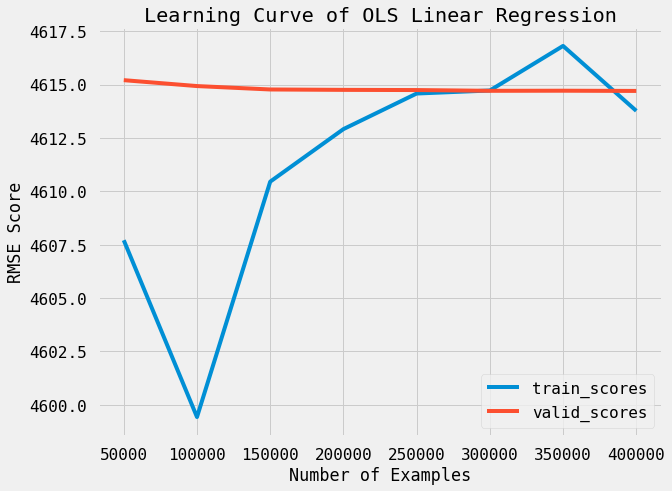

In [ ]:
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of OLS Linear Regression", y_label = "RMSE Score")

As we can see, model is severely suffered from underfitting and it is not result we want for the baseline model (because it seems that validation score is flatten no matter we increate the number of samples). Then we decided to increase our complexity by using [Polynomial Regression](https://en.wikipedia.org/wiki/Polynomial_regression#:~:text=In%20statistics%2C%20polynomial%20regression%20is,nth%20degree%20polynomial%20in%20x.) which increases the number of dimensions in our data.



### Polynomial Regression

First, we create a poly transformer and transform X into X_transformed (with regard to the polynominal factor)

In [ ]:
poly_feature = PolynomialFeatures(degree=3, include_bias=False) # Class polynomial to create polynominal features
X_transformed = poly_feature.fit_transform(X)  # Transform the feature
X_transformed.shape

(550068, 285)

Due to the limitation of the hardwares, we are only tried until degree <= 3

Then we train the model

In [ ]:
poly_lr = LinearRegression(n_jobs = -1 )
metrics = {'RMSE': RMSE_score}

sv_scores = cross_validate(olr, X_transformed, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.iloc[:, [2,3]]  = np.abs(df_sv_scores.iloc[:, [2,3]])
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True) ])

,fit_time,score_time,test_RMSE,train_RMSE
0,15.944254,0.072289,4147.548695,4164.414210
1,15.145163,0.060618,4176.872173,4157.088359
2,15.195334,0.059651,4167.985145,4159.333238
3,15.010481,0.075454,4161.198487,4160.987525
4,15.295597,0.073966,4161.658026,4160.821367
mean,15.318166,0.068396,4163.052505,4160.528940
std,0.364754,0.007632,10.736203,2.676679


In [ ]:
df_results = df_results.append({"Model" : "Polynomial Regression" , 
                    "Parameters" : "degree = 3",
                   'RMSE mean': 4163.05,
                   'RMSE std':10.74, 
                   'Training time': 15.318, 
                   'Prediction time': 0.068,
                   'Evaluation techniques' : '5-fold\ncross-validation'
                   }, 
                  ignore_index = True)

So as we expected, the  `RMSE` decreases and it is nearly `4200`, which is lower than `OLS` about `500`, so we also need to check whether this model is still underfit or not ?

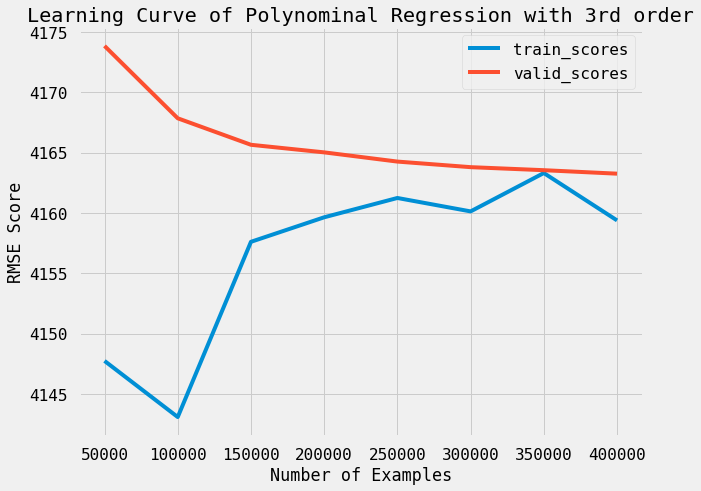

In [ ]:
## Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(poly_lr, X_transformed, y, train_sizes=[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = RMSE_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Polynominal Regression with 3rd order")

As we can see, the model is still underfit (the training score is unstable when increase number of examples), therefore we decided to choose other algorithm families (which is not variants of Linear Regression).

Because the dependent features in the dataset are all categorical so we all think about `Decision Tree` as decision tree work best when each attribute is nominal/categorical and this problem is regression so we choose to the model `Decision Tree Regressor` from `scikit-learn`.

### Decision Tree

In [ ]:
## Common parameters setting
dtr = DecisionTreeRegressor(max_depth = 3, min_samples_leaf=5, random_state= RANDOM_STATE)

metrics = {'RMSE': RMSE_score}
sv_scores = cross_validate(dtr, X, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.iloc[:, [2,3]]  = np.abs(df_sv_scores.iloc[:, [2,3]])
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_RMSE,train_RMSE
0,0.571917,0.008913,3734.742098,3749.702290
1,0.582698,0.008785,3754.836709,3744.683014
2,0.632395,0.009057,3741.154119,3748.110014
3,0.580151,0.012438,3754.824849,3744.686547
4,0.591271,0.009206,3748.166476,3746.349108
mean,0.591687,0.009680,3746.744850,3746.706195
std,0.023780,0.001550,8.776502,2.193573


As we expected, the model is much faster and produces better result `RMSE_score = 3746.74` than the two above models. But we need to check whether the model is underfit or not.

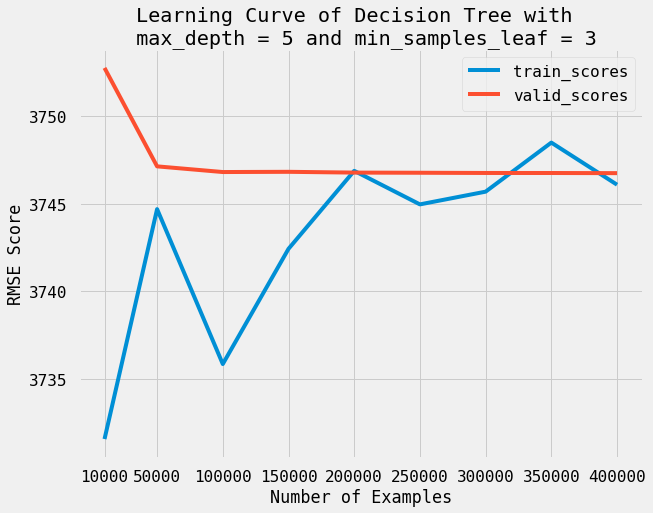

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(dtr, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = RMSE_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Decision Tree with \n max_depth = 5 and min_samples_leaf = 3")

As we can see, the model still suffers from underfit (the pattern is the same as OLS Regression). However, we will do hyperparameters tuning to choose the best the best one as we believe it could be better if changing suitable hyperparameters and use it by [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)



#### Tuning hyperparameters

In [ ]:
# Selected Parameters
tuned_parameters = [
      {'max_depth' : [1, 5, 10, 11,  12, 15, 25, 30, 35, 40, 45,50],
       'min_samples_leaf' : [1, 3, 5, 10 , 15, 20,23, 25, 33, 30, 35, 40]}]

#Grid Search 
dtrGrid = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),tuned_parameters, n_jobs = -1, cv = 5, scoring = RMSE_score ) ##Scoring using R2_score
dtrGrid.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=7777),
             n_jobs=-1,
             param_grid=[{'max_depth': [1, 5, 10, 11, 12, 15, 25, 30, 35, 40,
                                        45, 50],
                          'min_samples_leaf': [1, 3, 5, 10, 15, 20, 23, 25, 33,
                                               30, 35, 40]}],
             scoring=make_scorer(myRMSE, greater_is_better=False))

In [ ]:
print("The best setting for DTR:")
dtrGrid.best_estimator_

The best setting for DTR:


DecisionTreeRegressor(max_depth=25, min_samples_leaf=40, random_state=7777)

In [ ]:
pdtGrid_result = pd.DataFrame.from_dict(dtrGrid.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score' ,'std_test_score']
## Top 5 parameter settings
pdtGrid_display = pdtGrid_result[columns].sort_values(by='mean_test_score', ascending=False).head(5)

## Display abs score
pdtGrid_display.iloc[:, 3] = np.abs(pdtGrid_display.iloc[:, 3] )
pdtGrid_display

,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
83,3.846057,0.043192,"{'max_depth': 25, 'min_samples_leaf': 40}",2733.330432,7.019174
95,3.958772,0.041825,"{'max_depth': 30, 'min_samples_leaf': 40}",2733.706055,6.923657
119,3.855490,0.041341,"{'max_depth': 40, 'min_samples_leaf': 40}",2733.730735,6.954441
131,3.865886,0.046591,"{'max_depth': 45, 'min_samples_leaf': 40}",2733.730735,6.954441
107,3.948988,0.044281,"{'max_depth': 35, 'min_samples_leaf': 40}",2733.730735,6.954441


#### Choosing model based on the result of tuning hyperparameter

So we train and validate again with the optimal parameter resulting in lowest `test_score`.

In [ ]:
sv_scores = cross_validate(DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth=25, min_samples_leaf=40), X, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.iloc[:, [2,3]]  = np.abs(df_sv_scores.iloc[:, [2,3]])

df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_RMSE,train_RMSE
0,2.716674,0.031575,2732.505386,2577.714286
1,3.364031,0.060055,2737.924849,2577.946992
2,3.060445,0.032865,2720.915413,2579.245673
3,2.632792,0.032881,2741.718251,2578.933660
4,2.622047,0.031930,2733.588259,2577.683066
mean,2.879198,0.037861,2733.330432,2578.304736
std,0.324488,0.012420,7.847675,0.732119


In [ ]:
dtrGrid.best_estimator_

DecisionTreeRegressor(max_depth=25, min_samples_leaf=40, random_state=7777)

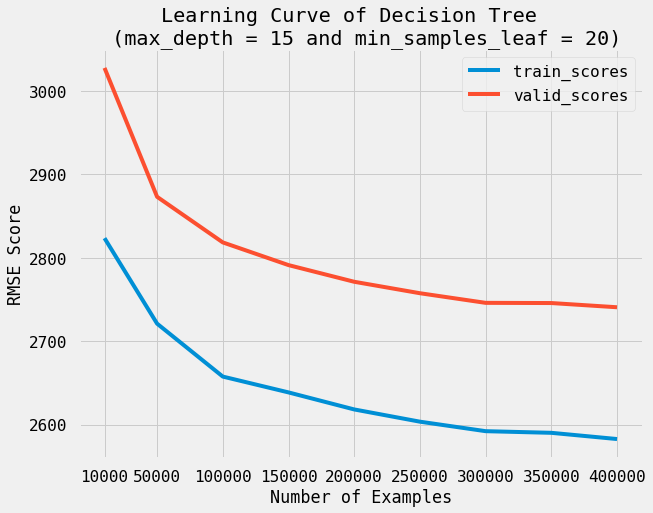

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(dtrGrid.best_estimator_, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = RMSE_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Decision Tree  \n (max_depth = 15 and min_samples_leaf = 20)")

Validation score and training score are both high (up to nearly `2735 RMSE score` for validation curve) however there is a big gap between `train_scores` and `valid_scores` and two curves are likely to meet each other when increasing the number of examples so it is a *overfitting* model .

In [ ]:
df_results = df_results.append({"Model" : "Decision Tree" , 
                    "Parameters" : "max_depth = 15,\nmin_sample_leaf = 20 ",
                   'RMSE mean':2733.33,
                   'RMSE std':7.85	, 
                   'Training time': 2.879	, 
                   'Prediction time': 0.038	,
                   'Evaluation techniques' : '5-fold\ncross-validation'
                   }, 
                  ignore_index = True)

Although `Decision Tree` yields good result, we also tried `Random Forest` which includes different decision trees and hopefully give us lower variances related to the data.

### Random Forest

In [ ]:
## Create RFR with selected paramaters by similar techniques
rfr = RandomForestRegressor(max_depth = None, min_samples_split= 5, random_state= RANDOM_STATE, n_jobs = -1, max_features="sqrt", n_estimators= 100)

metrics = {'RMSE': RMSE_score}
sv_scores = cross_validate(rfr, X, y, cv = 5, scoring =metrics, return_train_score = True)

We chose the parameters based on GridSearch strategies like above.

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.iloc[:, [2,3]]  = np.abs(df_sv_scores.iloc[:, [2,3]])
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_RMSE,train_RMSE
0,71.135068,4.019190,2737.189272,1661.517837
1,72.182295,4.217113,2746.281516,1661.653264
2,71.456591,4.316709,2728.972991,1660.850170
3,71.567727,4.117442,2740.657729,1659.577360
4,71.071991,4.016469,2740.273953,1659.556741
mean,71.482735,4.137385,2738.675092,1660.631074
std,0.443530,0.129906,6.338046,1.017808


Suprisingly, the `train_RMSE = 1660.63` which is much higher than other models while the `validation_RMSE = 2738.68` and the variance indeed decreases `std_validation_RMSE = 6.34`  but we wonder if the model is overfitting (big gap between train and validation score however in theory, it can not be happen as we decrease the variance)

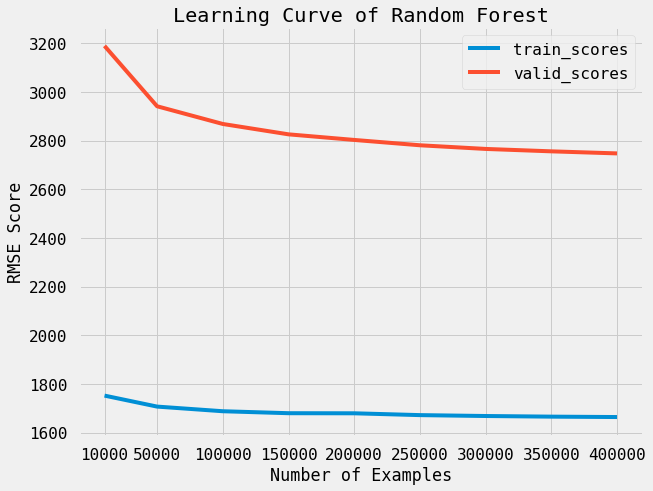

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(rfr, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = RMSE_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of Random Forest")

Indeed, we can easily see that the model is *overfitting*. So we decided to find the answer for the question "Why RF decreases the variances but it still suffers from overfitting?". Refer to this [article](https://mljar.com/blog/random-forest-overfitting/), they conclude that the generalization error variance is decreasing to zero in the RF when more trees are added to the algorithm. However, the bias of the generalization does not change. So it does not completely solve the overfitting problem and they suggest we need to consider other parameters of RF.

In [ ]:
df_results = df_results.append({"Model" : "Random Forest" , 
                    "Parameters" : "n_estimators= 100,\nmin_samples_split= 5,\nmax_features= sqrt ",
                   'RMSE mean':2738.68,
                   'RMSE std':6.34, 
                   'Training time': 71.483 , 
                   'Prediction time': 4.137,
                   'Evaluation techniques' : '5-fold\ncross-validation'
                   }, 
                  ignore_index = True)

RF is a bagging algorithm in ensemble learning so we also wanted to try another ensemble learning algorithm which is boosting. In this problem, we chose XGBoost as a reprensetative of all possible boosting algorithms.

### XGBoost

In [ ]:
## Create xgbModel with selected paramaters by similar techniques
xgbModel = XGBRegressor(objective ='reg:squarederror', random_state = RANDOM_STATE, n_estimator = 200, max_depth = 9 , subsample = 0.8)

metrics = {'RMSE': RMSE_score}
sv_scores = cross_validate(xgbModel, X, y, cv = 5, scoring =metrics, return_train_score = True)

In [ ]:
df_sv_scores = pd.DataFrame(sv_scores)
df_sv_scores.iloc[:, [2,3]]  = np.abs(df_sv_scores.iloc[:, [2,3]])
df_sv_scores.append([df_sv_scores.mean().rename('mean', inplace=True) ,df_sv_scores.std().rename('std', inplace=True)])

,fit_time,score_time,test_RMSE,train_RMSE
0,82.191202,1.152985,2618.731170,2524.739155
1,80.859790,1.150562,2633.651104,2530.349445
2,81.817620,1.126044,2604.535045,2526.569706
3,83.129589,1.146065,2618.110064,2522.291669
4,93.461432,1.137297,2618.922689,2523.201479
mean,84.291927,1.142590,2618.790014,2525.430291
std,5.190030,0.011017,10.302179,3.193453


Obviously, the result is much better than aforementioned models but we also wonder if it is well-fit or not? 

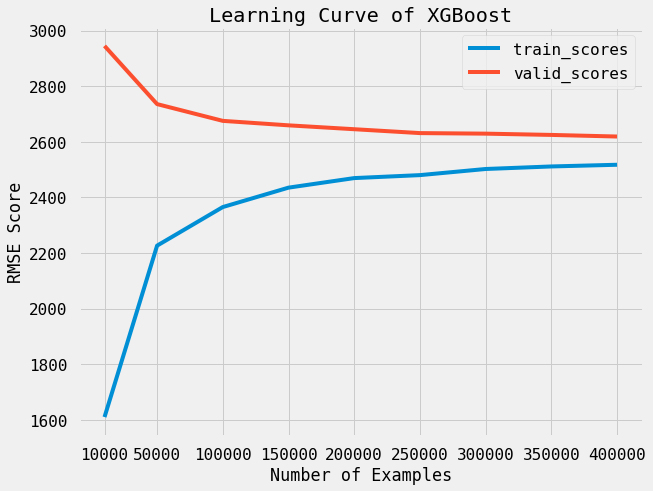

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(xgbModel, X, y, train_sizes=[10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000], scoring = RMSE_score)
plot_learning_curve(train_sizes, train_scores, valid_scores, title = "Learning Curve of XGBoost")

Indeed, the model is *well-fit*. However we think we can improve the model more by better tuning parameters.

In [ ]:
df_results = df_results.append({"Model" : "XGBoost" , 
                    "Parameters" : "n_estimators= 200,\nmin_samples_split= 9,\nsubsample = 0.8 ",
                   'RMSE mean':2618.79,
                   'RMSE std':10.30, 
                   'Training time':	84.291, 
                   'Prediction time': 1.143,
                   'Evaluation techniques' : '5-fold\ncross-validation'
                   }, 
                  ignore_index = True)

We also wanted to try some instance-based models which is contradictory to our problem (which has a large number of sample) to see what would happen. K-Nearest Neighbors can yield better results than other models in general. However due to the limitation of hardware and the size of the dataset, we could only tried when the number of neighbors is less than 11. 

### K-Nearest Neighbors

Data preprocessing for KNN (as it's different)

In [ ]:
X_copy = X.copy()

In [ ]:
X_copy = pd.get_dummies(X, columns = ['Product_Category_1']).drop(['User_ID', 'Product_ID'] , 1)

As the time complexity of KNN is primally based on the number of instances in the dataset so we did not use cross-validation to evaluate KNN, instead of that, we just splitted our data into two parts (2 : 1)



In [ ]:
VAL_SIZE = 1 / 3 # Based on the lecture, we choose the popular split between Dtrain and Dtest
X_train, X_val, y_train, y_val = train_test_split(X_copy, y ,test_size= VAL_SIZE, random_state=RANDOM_STATE)

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 15, weights="uniform")
knnPipeline = make_pipeline(RobustScaler(), knn)

In [ ]:
timer.start()
knnPipeline.fit(X_train, y_train)
timer.tick("Training time for KNN: ")

Training time for KNN:  : 0.39502 seconds


In [ ]:
timer.start()
y_val_pred = knnPipeline.predict(X_val)
timer.tick("Prediction time for KNN: ")

Prediction time for KNN:  : 1529.52092 seconds


In [ ]:
print("RMSE score of KNN: ", end = "")
print(myRMSE(y_val, y_val_pred))

RMSE score of KNN: 2995.1383422640806


It takes a long time to predict the results of validation set but we wonder if the number of `K` increase, what could happened ?

In [ ]:
df_results = df_results.append({"Model" : "K-Nearest Neighbors" , 
                    "Parameters" : "k = 15",
                   'RMSE mean': 2995.14,
                   'RMSE std': "", 
                   'Training time':0.395 , 
                   'Prediction time': 1530,
                   'Evaluation techniques' : 'Hold-old (2:1)'
                   }, 
                  ignore_index = True)

We also tried to use collaborative filtering algorithm in recommendation systems.

### Collaborative Filtering (Code by our team members)

In [ ]:
trainset, valset = train_test_split(train_raw, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [ ]:
def partition (list_in, n):
  """
  The function to split a list into n parts
  """
  random.shuffle(list_in)
  return [list_in[i::n] for i in range(n)]

class Recommendation_System:
  def __init__(self, train):
    """
    This class is very simple model base on what we have learn from an old lesson
    taught by Mr.Andrew Ng
    """
    self.train = train
    # get the price range of product in category 1 
    # we later use these values to calculate the price of product base on their rating
    self.price = self.train.groupby(['Product_Category_1']).Purchase.agg(['min', 'max'])
    self.price['range'] = self.price['max'] - self.price['min']
    

  def processing_data(self, data):
    """
    Process the data from table to obtain rating matrices, rating status, 
    user information and initialize product information randomly
    """
    # use min-max scale to get the 0-to-5 rating of the product 
    data['rating'] = 5*(data['Purchase'] - data['Purchase'].min())/(data['Purchase'].max() - data['Purchase'].min())

    # hash user id
    user_id_dict = {}
    for idx, val in enumerate(list(data.User_ID.unique())):
      user_id_dict[val] = idx

    # hash product id
    product_id_dict = {}
    for idx, val in enumerate(list(data.Product_ID.unique())):
      product_id_dict[val] = idx

    # generate rating and status matrices
    rating = np.zeros((len(user_id_dict), len(product_id_dict)))
    status = np.zeros((len(user_id_dict), len(product_id_dict)))

    # set rating and status values
    # status will equal to 1 if that user bought(rated) that item
    for idx, row in data.iterrows():
      u = user_id_dict[row['User_ID']]
      p = product_id_dict[row['Product_ID']]

      rating[u, p] = row.rating
      status[u, p] = 1

    # creating dataframe from above matrices
    df_rating = pd.DataFrame(rating, columns = list(product_id_dict.keys()), index = list(user_id_dict.keys()))

    df_status = pd.DataFrame(status, columns = list(product_id_dict.keys()), index = list(user_id_dict.keys()))

    # create new dataframe that contain user information
    user_attribute = data.groupby(['User_ID',])[['Gender',	'Age', 	'Occupation', 'City_Category',	'Stay_In_Current_City_Years',	'Marital_Status']].apply(lambda x: x.mode().iloc[0])
    df_user = pd.DataFrame(user_attribute).sort_values(by=['User_ID'])
    df_user = pd.get_dummies(df_user)

    # initialize the product dataframe randomly before training
    df_product = pd.DataFrame(np.random.rand(rating.shape[1], df_user.shape[1]), columns = list(df_user.columns), index = list(product_id_dict.keys()))

    # save number of user and product for later usage
    self.n_u = df_rating.shape[0]
    self.n_p = df_rating.shape[1]

    return df_user, df_product, df_rating, df_status, user_id_dict, product_id_dict


  def costfunction(self, X, y, r, theta, Lambda):
    """ 
    This function return the cost function of the model
    """
    predictions = np.dot(X, theta.T)* r
    err = predictions-y
    J = 1/2 * np.sum(np.sum((err**2) ))
    # adding regularization term
    reg_x = Lambda/2 * np.sum(np.sum(theta**2))
    reg_theta = Lambda/2 * np.sum(np.sum(X**2))
    return J + reg_x + reg_theta


  def sgd(self, X, y, r, theta, batch_size, Lambda, num_iter, alpha):
    """
    This function apply stochastic gradient descent to find optimal value 
    """

    # calculate the number of batch base on the size
    n_batch = int(self.n_u/batch_size)
    # save the value of J for later plotting to check whether the algorithm converges or diverges
    J_hist = []
    for i in range(num_iter):
      batch = partition (list(range(self.n_u)), n_batch)

      for i in range(len(batch)):
        # here we generate temporary X, y, r having size equal to batch size
        temp_X = X.iloc[batch[i]]
        temp_Y = y.iloc[batch[i]]
        temp_r = r.iloc[batch[i]]

        # calculating cost function each iteration
        cost = self.costfunction(temp_X, temp_Y, temp_r, theta, Lambda)
        # using gradient to find the optimal value for theta
        theta = theta - alpha*(np.dot((np.dot(temp_X, theta.T)*temp_r - temp_Y).T, temp_X) + Lambda*theta) 
        # add the cost to history list
        J_hist.append(cost)
    return theta, J_hist

  
  def fit(self):
    """
    Fit the training data
    This funciton return the history of cost function which provide information
    about the algorithm convergence
    """

    # process table data to appropriate form
    df_train_user, df_train_product, df_train_rating, df_train_status, user_dict, product_dict = self.processing_data(self.train)
    # find optimal theta by applying sgd
    # these parameter are not carefully selected, they just select by our experience
    theta, J_hist = self.sgd(df_train_user, df_train_rating, df_train_status, df_train_product,500, 10, 20, 0.00001)
    # save theta
    self.theta = theta

    return J_hist

  def predict(self, test):
    """
    Predict rating function
    """
    test_copy = test.copy()
    # get the mean value of product attribute to use when we have a brand new product
    mean = pd.DataFrame(self.theta.describe().loc['mean'])

    # add new column Purchase
    if 'Purchase' not in test.columns:
      test['Purchase'] = np.nan

    # process the data to appropriate form 
    df_test_user, df_test_product, df_test_rating, df_test_status, user_dict, product_dict  = self.processing_data(test_copy)

    # set all new product attribute equal to mean
    idx = list(mean.index)

    # set all attributes of product to mean value
    # if we have seen this product before and have trained to get a optimal value,
    # we will replace them by ours
    for i in range(len(idx)):
      df_test_product[idx[i]] = mean.iloc[[i], [0]].values[0, 0]

    # find similar product between training set and testing set
    similarity_idx = df_test_product.index.intersection(self.theta.index)
    # set the parameter of common values to our trained values
    df_test_product.loc[similarity_idx] = self.theta.loc[similarity_idx]
    # append new product to our product list, which can use for training and testing later
    self.theta = self.theta.append(df_test_product.loc[df_test_product.index.difference(self.theta.index)])
    # calculate the rating
    result = np.dot(df_test_user, df_test_product.T)* df_test_status
    # set the columns for the result dataframe
    result.columns = list(product_dict)
    # create new dataframe having the index as the product id
    result = pd.DataFrame(result, index=list(user_dict))

    # calculate the price from rating and average price of product
    for i, r in test.iterrows():
      test_copy.at[i , 'Purchase'] = result.loc[[r.User_ID], [r.Product_ID]].values[0, 0] * self.price.loc[[r.Product_Category_1]].values[0, 2] /5 + self.price.loc[[r.Product_Category_1]].values[0, 0]

    return test_copy

In [ ]:
rs = Recommendation_System(trainset)

In [ ]:
timer.start()
hist = rs.fit()
timer.tick("Training time for CF: ")

Training time for CF:  : 67.71340 seconds


In [ ]:
rs_pred_trainset = rs.predict(trainset)

In [ ]:
timer.start()
rs_pred_valset = rs.predict(valset)
timer.tick("Prediction time for RS: ")

Prediction time for RS:  : 338.07070 seconds


In [ ]:
rs_pred_trainset_result_y = rs_pred_trainset['Purchase']
trainset_y = trainset['Purchase']
rs_pred_valset_result_y = rs_pred_valset['Purchase']
valset_y = valset['Purchase']

In [ ]:
print("RMSE of the val set:", end = " ")
print(myRMSE(rs_pred_valset_result_y, valset_y))

RMSE of the val set: 4311.767987446348


The result is not as we expected but it just likes our experiment.

In [ ]:
df_results = df_results.append({"Model" : "Collaborative Filtering" , 
                    "Parameters" : "",
                   'RMSE mean':  4311.77,
                   'RMSE std': "", 
                   'Training time':67.713 , 
                   'Prediction time': 338.071,
                   'Evaluation techniques' : 'Hold-out (2:1)'
                   }, 
                  ignore_index = True)

<a name="conclusion"></a>
##7.&nbsp;Conclusion

In [ ]:
# Beautiful format 
df_results.rename(columns={"RMSE mean": "RMSE_mean", "RMSE std": "RMSE_std" , "Training time" : "Training time(s)", "Prediction time" : "Prediction time(s)", "Evaluation techniques" : "Evaluation technique"} ,inplace=True)

df_results.style.format({'RMSE_mean' : "{:.7}", 'RMSE_std' : "{:.4}", 'Training time(s)' : "{:.6}", 'Prediction time(s)' : "{:.7}"}).set_properties(**{
    'text-align': 'center',
    'white-space': 'pre-wrap',}).set_table_styles([dict(selector="th", props=[("font-size", "100%"),
                               ("text-align", "center")])])


,Model,RMSE_mean,RMSE_std,Training time(s),Prediction time(s),Parameters,Evaluation technique
0,OLS Linear Regression,4614.7,8.76,0.172,0.015,,5-fold cross-validation
1,Polynomial Regression,4163.05,10.74,15.318,0.068,degree = 3,5-fold cross-validation
2,Decision Tree,2733.33,7.85,2.879,0.038,"max_depth = 15, min_sample_leaf = 20",5-fold cross-validation
3,Random Forest,2738.68,6.34,71.483,4.137,"n_estimators= 100, min_samples_split= 5, max_features= sqrt",5-fold cross-validation
4,XGBoost,2618.79,10.3,84.291,1.143,"n_estimators= 200, min_samples_split= 9, subsample = 0.8",5-fold cross-validation
5,K-Nearest Neighbors,2995.14,,0.395,1530.0,k = 15,Hold-old (2:1)
6,Collaborative Filtering,4311.77,,67.713,338.071,,Hold-out (2:1)


As we can see, the best model is `XGBoost` with `RMSE_mean = 2618.79`  

In [ ]:
df_results.drop('RMSE_std', 1, inplace=True)
df_results.style.format({'RMSE_mean' : "{:.7}", 'RMSE_std' : "{:.4}", 'Training time(s)' : "{:.6}", 'Prediction time(s)' : "{:.7}"}).set_properties(**{
    'text-align': 'center',
    'white-space': 'pre-wrap',}).set_table_styles([dict(selector="th", props=[("font-size", "100%"),
                               ("text-align", "center")])])


,Model,RMSE_mean,Training time(s),Prediction time(s),Parameters,Evaluation technique
0,OLS Linear Regression,4614.7,0.172,0.015,,5-fold cross-validation
1,Polynomial Regression,4163.05,15.318,0.068,degree = 3,5-fold cross-validation
2,Decision Tree,2733.33,2.879,0.038,"max_depth = 15, min_sample_leaf = 20",5-fold cross-validation
3,Random Forest,2738.68,71.483,4.137,"n_estimators= 100, min_samples_split= 5, max_features= sqrt",5-fold cross-validation
4,XGBoost,2618.79,84.291,1.143,"n_estimators= 200, min_samples_split= 9, subsample = 0.8",5-fold cross-validation
5,K-Nearest Neighbors,2995.14,0.395,1530.0,k = 15,Hold-old (2:1)
6,Collaborative Filtering,4311.77,67.713,338.071,,Hold-out (2:1)
